# Install and import requirements

In [ ]:
%pip install rasterio
%pip install boto3
%pip install pyproj
%pip install earthpy
%pip install sat-search

In [283]:
import matplotlib.pyplot as plt
from rasterio.features import bounds
import rasterio as rio
import boto3
from matplotlib import pyplot as plt
import satsearch
from pyproj import Transformer
import numpy as np
from matplotlib.colors import ListedColormap
import earthpy.plot as ep
import numpy as np
from sklearn import cluster
import matplotlib.pyplot as plt

# Helper functions

In [213]:
def getDataSubset(geotiff_file, bbox, aws_access_key_id="ACCESS_KEY", aws_secret_access_key="SECRET_KEY"):
  """
  Gets the data range defined by a polygon from a GeoTIFF file stored in a AWS S3 bucket

  Parameters
  ----------
  geotiff_file : str
      The URL of the GeoTIFF file
  bbox : tuple
      The four coordinates defining the polygon
  aws_access_key_id : str
      AWS Access Key ID (The account must have a S3 Read policy associated)
  aws_secret_access_key : str
      AWS Secret Access Key 
  """
  aws_session = rio.session.AWSSession(boto3.Session(aws_access_key_id=aws_access_key_id,
                                     aws_secret_access_key=aws_secret_access_key), requester_pays=True)
  with rio.Env(aws_session):
      with rio.open(geotiff_file) as geo_fp:
          # Calculate pixels with PyProj
          Transf = Transformer.from_crs("epsg:4326", geo_fp.crs)
          lat_north, lon_west = Transf.transform(bbox[3], bbox[0])
          lat_south, lon_east = Transf.transform(bbox[1], bbox[2])
          x_top, y_top = geo_fp.index(lat_north, lon_west)
          x_bottom, y_bottom = geo_fp.index(lat_south, lon_east)
          # Define window in RasterIO
          window = rio.windows.Window.from_slices(
              (x_top, x_bottom), (y_top, y_bottom))
          # Actual HTTP range request
          subset = geo_fp.read(1, window=window)
  return subset

In [187]:
def getNDVI(nir, red):
    """
    Calculates the Normalized Difference Vegetation Index from the Red and NIR bands
    
    Parameters
    ----------
    nir : ndarray
        NIR band
    red : ndarray
        Red band
    """
    ndvi = (nir.astype(float)-red.astype(float)) / \
        (nir.astype(float)+red.astype(float))
    return ndvi

In [210]:
def buildRectangle(lon, lat, delta_lon=0.0275, delta_lat=0.01):
    """
    Calculates the corner coordinates for a polygon centered in a given point, having the width and height specified
    
    Parameters
    ----------
    lon : float
      Longitude of the center point
    lat : float
      Latitude of the center point
    delta_lon : float
      Rectangle height (in degrees)
    delta_lat : float
      Rectangle width (in degrees)
    """
    c1 = [lon + delta_lon, lat + delta_lat]
    c2 = [lon + delta_lon, lat - delta_lat]
    c3 = [lon - delta_lon, lat - delta_lat]
    c4 = [lon - delta_lon, lat + delta_lat]
    rectangle = {"type": "Polygon", "coordinates": [[c1, c2, c3, c4, c1]]}
    return rectangle

In [251]:
def getImageLinks(rectangle):
  """
  Returns an array of links (four for each year, corresponding to the red, green, blue and NIR bands)
  
  Parameters
  ----------
  lon : float
    Longitude of the center point
  lat : float
    Latitude of the center point
  deltalon : float
    Rectangle height (in degrees) (optional, defaults to 0.0275)
  deltalat : float
    Rectangle width (in degrees) (optional, defaults to 0.01)
  """

  SentinelSearch = satsearch.Search.search(
      url="https://earth-search.aws.element84.com/v0",
      bbox=bounds(rectangle),
      query={"eo:cloud_cover":{"lt":10},
             "sentinel:valid_cloud_cover": {"eq": True}},
      collections=['sentinel-s2-l2a'])

  sentinel_items = SentinelSearch.items()

  items = []
  years = set()
  months = dict()
  selected_month = dict()

  for item in sentinel_items:
    list_split = item.assets['B04']['href'].split('/')
    year = list_split[7]
    month = list_split[8]
    day = list_split[9]
    if year not in years:
      years.add(year)
      months[year] = set()
    else:
      months[year].add(month)

  month_order = ['6', '7', '5', '8', '4', '3', '9', '10', '11', '12', '2', '1']

  for year, months in months.items():
    for m in month_order:
      if m in months:
        selected_month[year] = m
        break

  links = []

  for item in sentinel_items:
    red_s3 = item.assets['B04']['href']
    blue_s3 = item.assets['B02']['href']
    green_s3 = item.assets['B03']['href']
    nir_s3 = item.assets['B08']['href']
    list_split = item.assets['B04']['href'].split('/')
    year = list_split[7]
    month = list_split[8]
    day = list_split[9]
    if year in selected_month:
      if month == selected_month[year]:
        del selected_month[year]
        links.append({'red': red_s3, 'nir': nir_s3, 'green': green_s3, 'blue': blue_s3})

  return links

# Get Sentinel images links from coordinates

In [250]:
def linksHandler(lon, lat, delta_lon=0.0275, delta_lat=0.01):
  """
  Returns an array of links (four for each year, corresponding to the red, green, blue and NIR bands)
  
  Parameters
  ----------
  lon : float
    Longitude of the center point
  lat : float
    Latitude of the center point
  deltalon : float
    Rectangle height (in degrees) (optional, defaults to 0.0275)
  deltalat : float
    Rectangle width (in degrees) (optional, defaults to 0.01)
  """

  rectangle = buildRectangle(lon, lat, delta_lon, delta_lat)
  return getImageLinks(rectangle)

# Render area in true color and calculate forest mask for a certain date

In [252]:
def calculateForestMask(green, ndvi):
  """
  Returns the forest mask as an binary array where 1 signifies that the coresponding pixel is part of a forest
  
  Parameters
  ----------
  green : ndarray
    Green band
  ndvi : ndarray
    Calculated NVDI
  """
  
  n_clusters = 4

  new_shape = (ndvi.shape[0] * ndvi.shape[1], 1)

  X = green.reshape(new_shape)

  k_means = cluster.KMeans(n_clusters)
  k_means.fit(X)
  clusters = k_means.labels_

  return clusters.reshape(ndvi.shape)

In [278]:
def saveMaskImage(clusters, ndvi):
  """
  Renders the forest mask using matplotlib.
  
  Parameters
  ----------
  clusters : ndarray
    Clusterized green band
  ndvi : ndarray
    Calculated NDVI
  """

  sums = dict()
  counts = dict()
  for i in range(clusters.shape[0]):
    for j in range(clusters.shape[1]):
      elem = clusters[i][j]
      n = ndvi[i][j]
      if elem in sums:
        sums[elem] += n
        counts[elem] += 1
      else:
        sums[elem] = 0.0 + n
        counts[elem] = 1

  max_avg = 0
  max_elem = -1
  for elem in sums:
    if sums[elem]/counts[elem] > max_avg:
      max_avg = sums[elem]/counts[elem]
      max_elem = elem

  if max_avg < 0.45:  # there is no cluster with a NDVI coresponding to a vegetation zone (> 0.45)
    max_elem = -1

  new_shape = (ndvi.shape[0] * ndvi.shape[1], 1)
  arr = np.array([1 if max_elem == num else 0 for num in clusters.reshape(new_shape)])

  nbr_colors = [(0, 0, 0, 0), "darkgreen"]
  nbr_cmap = ListedColormap(nbr_colors)

  plt.figure(figsize=(24,24))
  plt.imshow(arr.reshape(ndvi.shape), cmap=nbr_cmap)
  plt.axis('off')
  filename="mask.png"
  plt.savefig(filename,bbox_inches='tight',transparent=True, pad_inches=0)

  return filename

In [280]:
def saveColorImage(red, green, blue):
  """
  Renders the true color image using matplotlib.
  
  Parameters
  ----------
  red : ndarray
    Red band
  green : ndarray
    Green band
  blue : ndarray
    Blue band
  """

  fig, (ax1) = plt.subplots(1, 1, figsize=(24, 24))
  arr = np.array([red, green, blue])
  ep.plot_rgb(arr, ax=ax1)
  ax1.set_axis_off()
  plt.tight_layout()
  filename = "color.png"
  plt.savefig(filename, bbox_inches='tight', transparent=True, pad_inches=0)

  return filename

In [273]:
def imagesHandler(links_obj, lon, lat):
  """
  Based on a set of links corresponding to the red, green, blue and NIR bands, renders area defined by a polygon in true color and calculates forest mask.
  Both images are saved locally.
  
  Parameters
  ----------
  links_obj : dict
    Maps the keys "red", "green", "blue" and "nir" to a COG file URL, stored in a AWS S3 bucket
  lon : float
    Longitude of the center point
  lat : float
    Latitude of the center point
  """

  rectangle = buildRectangle(lon, lat)
  bbox = bounds(rectangle)

  red = getDataSubset(links_obj["red"], bbox)
  green = getDataSubset(links_obj["green"], bbox)
  blue = getDataSubset(links_obj["blue"], bbox)
  nir = getDataSubset(links_obj["nir"], bbox)

  # ndvi = getNDVI(nir, red)
  # mask = calculateForestMask(green, ndvi)
  # mask_filename = saveMaskImage(mask, ndvi)
  # color_filename = saveColorImage(red, green, blue)

  return red, green, blue, nir

# Workflow

In [268]:
lat = 45.40122035920218
lon = 26.92926339904113

In [269]:
%%time
links = linksHandler(lon, lat)

CPU times: user 69.9 ms, sys: 2.16 ms, total: 72.1 ms
Wall time: 1.73 s


In [270]:
links

[{'red': 's3://sentinel-s2-l2a/tiles/35/T/ML/2022/6/29/0/R10m/B04.jp2',
  'nir': 's3://sentinel-s2-l2a/tiles/35/T/ML/2022/6/29/0/R10m/B08.jp2',
  'green': 's3://sentinel-s2-l2a/tiles/35/T/ML/2022/6/29/0/R10m/B03.jp2',
  'blue': 's3://sentinel-s2-l2a/tiles/35/T/ML/2022/6/29/0/R10m/B02.jp2'},
 {'red': 's3://sentinel-s2-l2a/tiles/35/T/ML/2021/7/14/0/R10m/B04.jp2',
  'nir': 's3://sentinel-s2-l2a/tiles/35/T/ML/2021/7/14/0/R10m/B08.jp2',
  'green': 's3://sentinel-s2-l2a/tiles/35/T/ML/2021/7/14/0/R10m/B03.jp2',
  'blue': 's3://sentinel-s2-l2a/tiles/35/T/ML/2021/7/14/0/R10m/B02.jp2'},
 {'red': 's3://sentinel-s2-l2a/tiles/35/T/ML/2020/7/29/0/R10m/B04.jp2',
  'nir': 's3://sentinel-s2-l2a/tiles/35/T/ML/2020/7/29/0/R10m/B08.jp2',
  'green': 's3://sentinel-s2-l2a/tiles/35/T/ML/2020/7/29/0/R10m/B03.jp2',
  'blue': 's3://sentinel-s2-l2a/tiles/35/T/ML/2020/7/29/0/R10m/B02.jp2'},
 {'red': 's3://sentinel-s2-l2a/tiles/35/T/ML/2019/8/29/0/R10m/B04.jp2',
  'nir': 's3://sentinel-s2-l2a/tiles/35/T/ML/2019/8/

In [274]:
%%time
red, green, blue, nir = imagesHandler(links[0], lon, lat)

CPU times: user 3.85 s, sys: 322 ms, total: 4.18 s
Wall time: 2min 38s


In [275]:
%%time
ndvi = getNDVI(nir, red)

CPU times: user 1.3 ms, sys: 0 ns, total: 1.3 ms
Wall time: 1.31 ms


In [276]:
%%time
mask = calculateForestMask(green, ndvi)

CPU times: user 1.86 s, sys: 4.28 ms, total: 1.86 s
Wall time: 992 ms


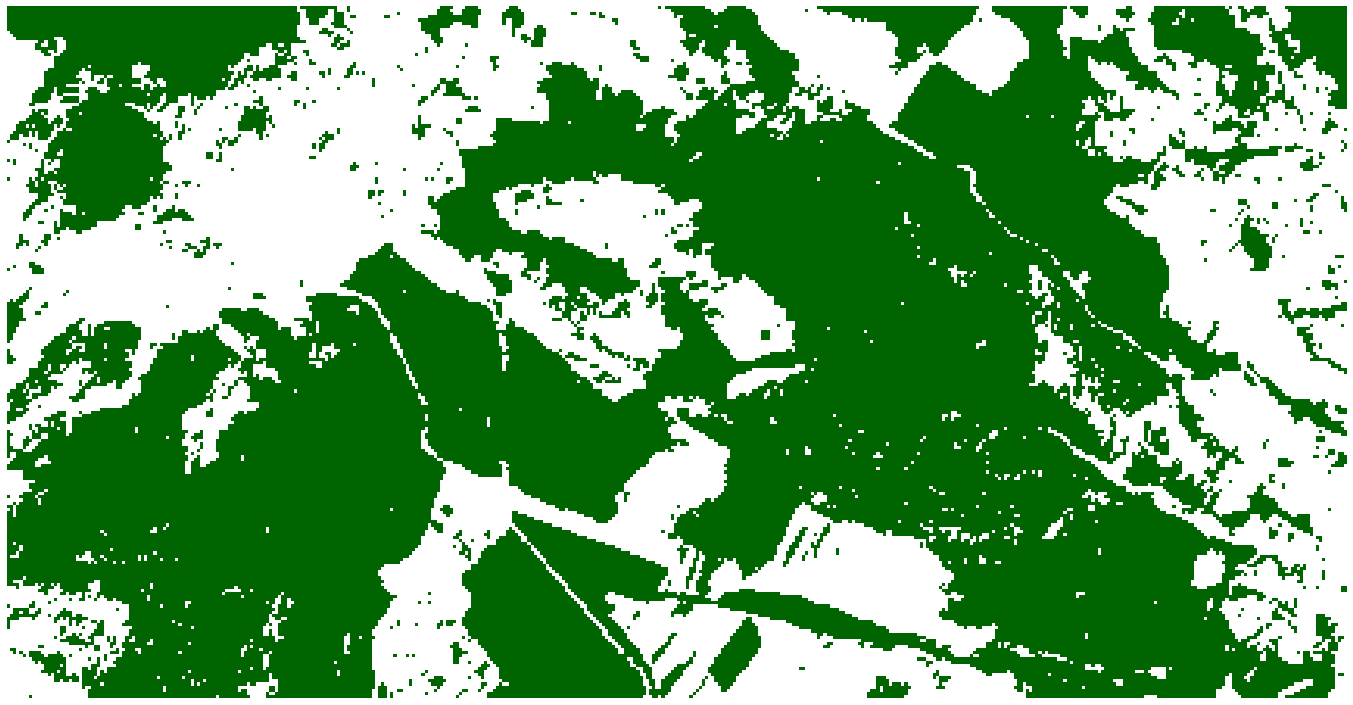

In [279]:
mask_filename = saveMaskImage(mask, ndvi)

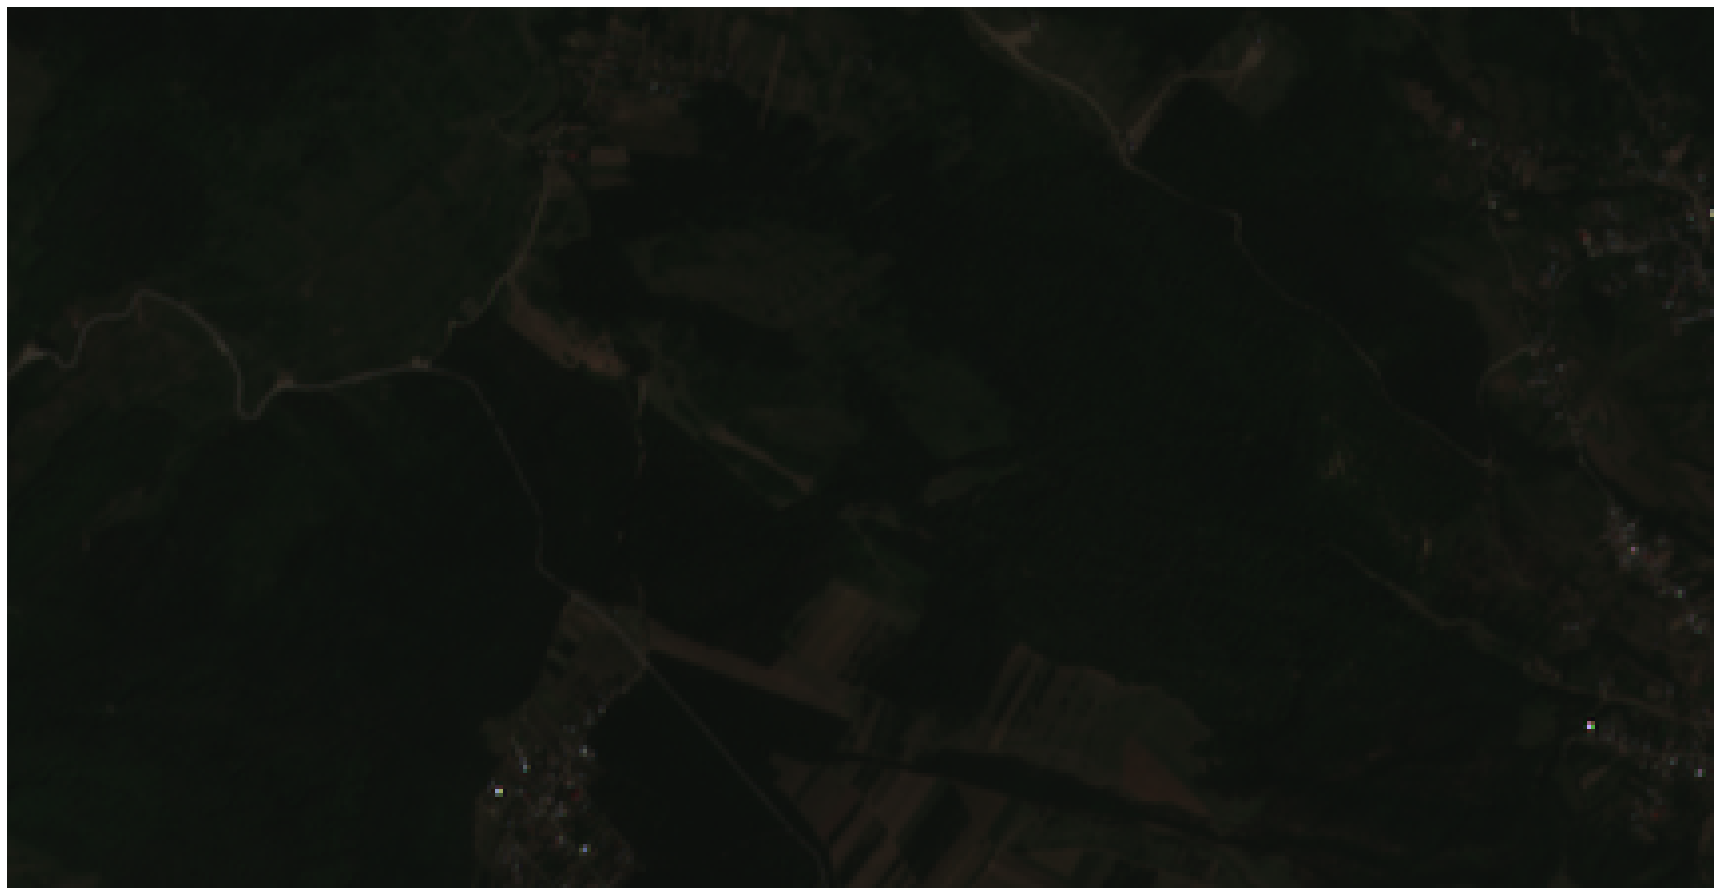

In [282]:
color_filename = saveColorImage(red, green, blue)